(model_averaging)=
# Model Averaging

:::{post} Aug 2024
:tags: model comparison, model averaging
:category: intermediate
:author: Osvaldo Martin
:::

In [1]:
import os

import arviz.preview as az
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [2]:
rng = np.random.seed(2741)
az.style.use("arviz-variat")

When confronted with more than one model we have several options. One of them is to perform model selection as exemplified by the PyMC examples {ref}`pymc:model_comparison` and the {ref}`GLM-model-selection`, usually is a good idea to also include posterior predictive checks in order to decide which model to keep. Discarding all models except one is equivalent to affirm that, among the evaluated models, one is correct (under some criteria) with probability 1 and the rest are incorrect. In most cases this will be an overstatment that ignores the uncertainty we have in our models. This is somewhat similar to computing the full posterior and then just keeping a point-estimate like the posterior mean; we may become overconfident of what we really know. You can also browse the {doc}`blog/tag/model-comparison` tag to find related posts. 

An alternative to this dilemma is to perform model selection but to acknowledge the models we discarded. If the number of models are not that large this can be part of a technical discussion on a paper, presentation, thesis, and so on. If the audience is not technical enough, this may not be a good idea.

Yet another alternative, the topic of this example, is to perform model averaging. The idea is to weight each model by its merit and generate predictions from each model, proportional to those weights. There are several ways to do this, including the three methods that will be briefly discussed in this notebook. You will find a more thorough explanation in the work by {cite:t}`Yao_2018` and {cite:t}`Yao_2022`. 


## Pseudo Bayesian model averaging

Bayesian models can be weighted by their marginal likelihood, which is known as Bayesian Model Averaging. While this is theoretically appealing, it is problematic in practice: on the one hand the marginal likelihood is highly sensitive to the specification of the prior, in a way that parameter estimation is not, and on the other, computing the marginal likelihood is usually a challenging task. Additionally, Bayesian model averaging is ﬂawed in the $\mathcal{M}$-open setting in which the true data-generating process is not one of the candidate models being ﬁt {cite:t}`Yao_2018`. A more robust approach is to compute the  expected log pointwise predictive density (ELPD).

$$
\sum_i^N \log \int \ p(y_i \mid \theta) \; p(\theta \mid y) d\theta
$$

where $N$ is the number of data points, $y_i$ is the i-th data point, $\theta$ are the parameters of the model, $p(y_i \mid \theta)$ is the likelihood of the i-th data point given the parameters, and $p(\theta \mid y)$ is the posterior distribution.

Once we have computed the ELPD for each model we can compute weights by doing

$$w_i = \frac {e^{dELPD_i}} {\sum_j^M e^{dELPD_i}}$$

Where $dELPD_i$ is the difference between the model with the best ELPD and the i-th model.

This approach is called pseudo Bayesian model averaging, or Akaike-like weighting and is an heuristic to compute the relative probability of each model (given a fixed set of models). Note that we exponetiate to "revert" the effect of the logarithm in the ELPD formula and the denominator is a normalization term to ensure that the weights sum up to one. With a pinch of salt, we can interpret these weights as the probability of each model explaining the data.

So far so good, but the ELPD is a theoretical quantity, and in practice we need to approximate it. To do so ArviZ offers two methods

* WAIC, Widely Applicable Information Criterion
* LOO, Pareto-Smooth-Leave-One-Out-Cross-Validation.

Both require and InferenceData with the log-likelihood group and are equally fast to compute. We recommend using LOO because it has better practical properties, and better diagnostics (so we known when we are having issues with the ELPD estimation).

## Pseudo Bayesian model averaging with Bayesian Bootstrapping

The above formula for computing weights is a nice and simple approach, but with one major caveat: it does not take into account the uncertainty in the computation of the ELPD. We could compute the standard error of the ELPD value (assuming a Gaussian approximation) and modify the above formula accordingly. Or we can do something more robust, like using a [Bayesian Bootstrapping](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/) to estimate, and incorporate this uncertainty.

## Stacking

The third approach we will discuss is known as _stacking of predictive distributions_ by {cite:t}`Yao_2018`. We want to combine several models in a metamodel in order to minimize the divergence between the meta-model and the _true_ generating model. When using a logarithmic scoring rule this is equivalent to:

$$\max_{w} \frac{1}{n} \sum_{i=1}^{n}log\sum_{k=1}^{K} w_k p(y_i \mid y_{-i}, M_k)$$

Where $n$ is the number of data points and $K$ the number of models. To enforce a solution we constrain $w$ to be $w_k \ge 0$ and  $\sum_{k=1}^{K} w_k = 1$. 

The quantity $p(y_i \mid y_{-i}, M_k)$ is the leave-one-out predictive distribution for the $M_k$ model. Computing it requires fitting each model $n$ times, each time leaving out one data point. Fortunately, this is exactly what LOO approximates in a very efficient way. So we can use LOO and stacking together. To be fair, we can also use WAIC, even when WAIC approximates the ELPD in a different way.

## Weighted posterior predictive samples

Once we have computed the weights, using any of the above 3 methods, we can use them to get weighted posterior predictive samples. We will illustrate how to do it using the body fat dataset {cite}`penrose1985`. This dataset has measurements from 251 individuals, including their weight, height, the circumference of the abdomen, the circumference of the wrist etc. Our purpose is to predict the percentage of body fat, as estimated by the siri variable, also available from the dataset.

Let's start by loading the data

In [3]:
try:
    d = pd.read_csv(os.path.join("..", "data", "body_fat.csv"))
except FileNotFoundError:
    d = pd.read_csv(pm.get_data("body_fat.csv"))

d.head()

,siri,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.3,23,70.1,172,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.8,184,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,70.0,168,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,84.0,184,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.8,181,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Now that we have the data we are going to build two models, both are simple linear regressions the difference is that for the first one we are going to use the variables `abdomen`, and for the second one we are going to use the variables `wrist`, `height` and `weight`.

In [4]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + beta * d["abdomen"]

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_0 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [siri]


Output()

In [5]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=3)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + pm.math.dot(beta, d[["wrist", "height", "weight"]].T)

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_1 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [siri]


Output()

Before LOO (or WAIC) to compare and or average models we should check that we do not have sampling issues and posterior predictive checks are reasonable. For the sake of brevity we are going to skip these steps and instead jump to the model averaging.

First we need to call `az.compare` to compute the LOO values for each model and the weights using `stacking`. These are the default options, if you want to perform pseudo Bayesian model averaging you can use the `method='BB-pseudo-BMA'` that includes the Bayesian Bootstrap estimation of the uncertainty in the ELPD.


In [6]:
model_dict = dict(zip(["model_0", "model_1"], [idata_0, idata_1]))
comp = az.compare(model_dict)
comp

,rank,elpd,p,elpd_diff,weight,se,dse,warning
model_1,0,-817.208226,3.624837,0.000000,0.638945,10.449718,0.000000,False
model_0,1,-825.334583,1.834987,8.126357,0.361055,9.987935,8.649882,False


We can see from the column `weight`, that `model_1` has a weight of $\approx 0.6$ and `model_2` has a weight $\approx 0.4$. To use this weights to generate posterior predictive samples we can use the `az.weighted_posterior` function. This function takes the InferenceData objects and the weights and returns a new InferenceData object.

In [7]:
import arviz as azl

ppc_w = azl.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)

In [8]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz-stats/src/arviz_stats/manipulation.py:189: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  sample_dims=list(new_idatas[0].dims.keys()),


From the following plot we can see that the avearged model is a combination of the two models.

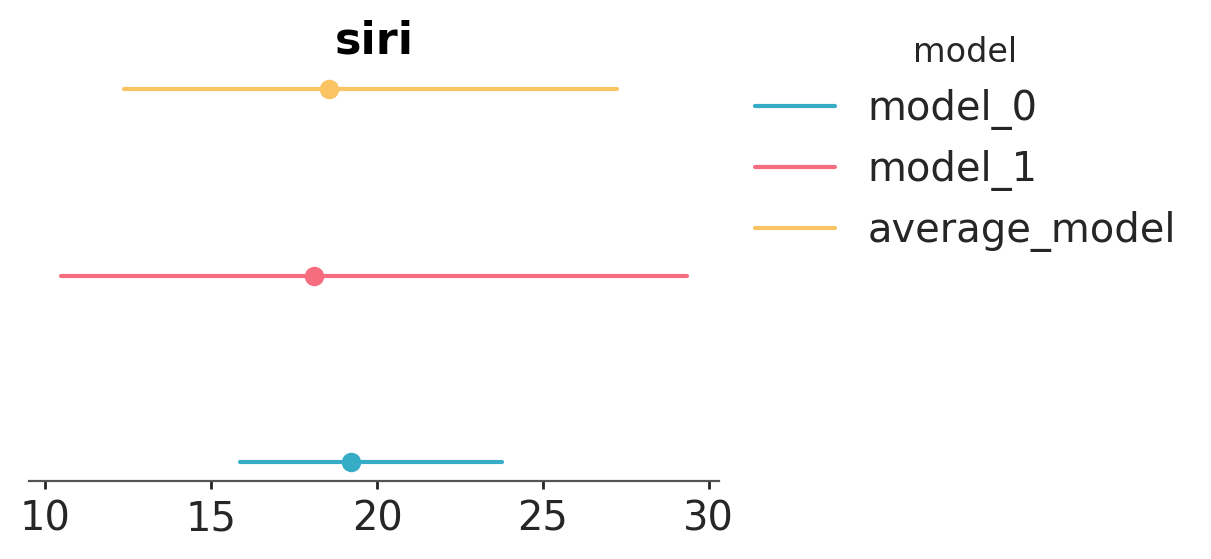

In [9]:
import xarray as xr

models = {
    "model_0": xr.Dataset({"siri": idata_0.posterior_predictive["siri"].mean(["chain", "draw"])}),
    "model_1": xr.Dataset({"siri": idata_1.posterior_predictive["siri"].mean(["chain", "draw"])}),
    "average_model": xr.Dataset({"siri": ppc_w.posterior_predictive["siri"].mean(["sample"])}),
}

pc = az.plot_dist(
    models,
    visuals={"dist": False, "point_estimate_text": False},
    point_estimate="median",
    sample_dims=["siri_dim_0"],
)
pc.add_legend("model");

## To do or not to do?

Model averaging is a good idea when you want to improve the robustness of your predictions. Usually a combinations of models will have better predictive performance than any single model. This is specially true when the models are complementary. Something we have not explored in this example is to assign weights to models in a way that they vary for different parts of the data. This can be done as discussed in {cite:t}`Yao_2022`.

When not do to model averaging? Many times we can create new models that effectively work as averages of other models. For instance in this example we could have created a new model that includes all the variables. That's actually a very sensible thing to do. Notice that if a model excludes a variable thats equivalent to setting the coefficient of that variable to zero. If we average a model with the variable and without it, it's like setting the coefficient to a value between zero and the value of the coefficient in the model that includes the variable. This is a very simple example, but the same reasoning applies to more complex models.

Hierarchical models are another example were we build a continuous version of a model instead of dealing with discrete versions. A toy example is to imagine that we have a coin and we want to estimated its degree of bias, a number between 0 and 1 having a 0.5 equal chance of head and tails (fair coin). We could think of two separate models: one with a prior biased towards heads and one with a prior biased towards towards tails. We could fit both separate models and then average them. An alternative is to build a hierarchical model to estimate the prior distribution. Instead of contemplating two discrete models, we would be computing a continuous model that considers the discrete ones as particular cases. Which approach is better? That depends on our concrete problem. Do we have good reasons to think about two discrete models, or is our problem better represented with a continuous bigger model?

## Authors

* Authored by Osvaldo Martin in June 2017 ([pymc#2273](https://github.com/pymc-devs/pymc/pull/2273))
* Updated by Osvaldo Martin in December 2017 ([pymc#2741](https://github.com/pymc-devs/pymc/pull/2741))
* Updated by Marco Gorelli in November 2020 ([pymc#4271](https://github.com/pymc-devs/pymc/pull/4271))
* Moved from pymc to pymc-examples repo in December 2020 ([pymc-examples#8](https://github.com/pymc-devs/pymc-examples/pull/8))
* Updated by Raul Maldonado in February 2021 ([pymc#25](https://github.com/pymc-devs/pymc-examples/pull/25))
* Updated Markdown and styling by @reshamas in August 2022, ([pymc-examples#414](https://github.com/pymc-devs/pymc-examples/pull/414))
* Updated notebook to use pymc 5 by Adrien Porter in November 2023 
* Updated by Osvaldo Martin in August 2024
* Updated by Osvaldo Martin in Dec 2025

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Dec 03 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

pymc  : 5.26.1
xarray: 2025.6.1
pandas: 2.3.0
numpy : 2.2.6
arviz : 0.23.0.dev0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::